In [183]:
#%% Modules
###############################################################################
import pandas as pd                                     ## Dataframes
import numpy as np                                      ## Numeric methods
import statsmodels as sm                                ## Statistical models
import statsmodels.formula.api as smf                   ## Formulas
import time
from sklearn.preprocessing import scale 
import os, sys, importlib 

# Quantile regression results stopping on crisis date, dependent variable is one year later

In [143]:
class QuantileReg(object):
    """ 
    Fit a conditional regression model, via quantile regressions

    Inputs:
    - depvar: string, dependent variable 
    - indvars: list of independent variables
    - quantile_list: list of quantiles to run the fit on
    - data = data to train the model on
    - scaling: zscore of the variables: standardized coefficients
    - alpha: the level of confidence to compute the confidence intervals
    
    Output:
    - qfit_dict = regressions fit, per quantiles (statsmodels object)
    - mfit = OLS regression fit, for the conditional mean
    - coeff = coefficients of the quantile regression, for every quantile
    - cond_quant: conditional quantiles and mean 

    Usage:
    qr = QuantileReg('y_growth_fwd_4', indvars=p_indvars, quantile_list=ql,
                     data=df, scaling=True, alpha=0.2)

    """
    __description = "Conditional quantiles, based on quantile regressions"
    __author = "Romain Lafarguette, IMF/MCM, rlafarguette@imf.org"

    ## Initializer
    def __init__(self, depvar, indvars, quantile_list, data, scaling=True,
                 alpha=0.1):

        ## Parameters
        self.scaling = scaling
        self.alpha = alpha
        self.quantile_list = quantile_list
        
        ## Variables
        self.depvar = depvar

        ## Data cleaning for the regression
        self.data = data.dropna()


        ## All data
        
        ## List of regressors
        self.regressors = [x for x in indvars if x in self.data.columns]

        ## Formula regression
        self.reg_formula = self.__reg_formula()
        
        ## Depending on user input, scale the variables
        vars_reg = [self.depvar] + self.regressors
        if self.scaling == True:
            self.data.loc[:, vars_reg] = scale(self.data.loc[:, vars_reg])
        else:
            pass
        
        ## From class methods (see below)
        self.qfit_dict = self.__qfit_dict()
        self.mfit = self.__mfit()
        self.coeff = self.__coeff()

        ## Conditional quantiles: use as predictors the historical regressors
        ## Basically, in-sample prediction but can be customized
        self.cond_quant = self.cond_quantiles(predictors=data)
        
    ## Methods
    def __reg_formula(self):
        """ Specify the formula for the quantile regressions """
        regressors_l = self.regressors[0]
        for v in self.regressors[1:]: regressors_l += ' + {0}'.format(v)
        reg_f = '{0} ~ {1}'.format(self.depvar, regressors_l)
        return(reg_f)

    def __qfit_dict(self): 
        """ Estimate the fit for every quantiles """
        qfit_dict = dict()
        for tau in self.quantile_list:
            reg_f = self.reg_formula
            qfit = smf.quantreg(formula=reg_f, data=self.data).fit(q=tau,
                                                                   maxiter=2000,
                                                                   p_tol=1e-05)


            qfit_dict[tau] = qfit
        return(qfit_dict)

    def __mfit(self): 
        """ Estimate the fit for every quantiles """
        mfit = smf.ols(self.reg_formula, data=self.data).fit()
        return(mfit)
    
    def __coeff(self):
        """ Extract the parameters and package them into pandas dataframe """
        params = pd.DataFrame()
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            stats = [qfit.params,qfit.pvalues,qfit.conf_int(alpha=self.alpha)]
            stats_names = ['coeff', 'pval', 'lower', 'upper']
            dp = pd.concat(stats, axis=1); dp.columns = stats_names
            dp.insert(0, 'quantile', qfit.q) # Insert as a first column
            dp['R2_in_sample'] = qfit.prsquared
            #dp = dp.loc[dp.index != 'Intercept',:].copy()
            ## Add the scaling information
            dp.loc[:,'normalized'] = self.scaling
            params = pd.concat([params, dp], axis=0) #params = params.append(dp)
        
        ## For information,  coeffs from an OLS regression (conditional mean)
        mfit = self.mfit
        stats = [mfit.params, mfit.pvalues, mfit.conf_int(alpha=self.alpha)]
        stats_names = ['coeff', 'pval', 'lower', 'upper']
        dmp = pd.concat(stats, axis=1); dmp.columns = stats_names
        dmp.insert(0, 'quantile', 'mean') # Insert as a first column
        dmp['R2_in_sample'] = mfit.rsquared
        #dmp = dmp.loc[dmp.index != 'Intercept',:].copy()
        ## Add the scaling information
        dmp.loc[:,'normalized'] = self.scaling
        coeff = pd.concat([params, dmp], axis='index')
        
        ## Return the full frame
        return(coeff)
    
    def cond_quantiles(self, predictors):
        """ 
        Estimate the conditional quantiles in sample 
        - Predictors have to be a pandas dataframe with regressors as columns
        """
        cond_quantiles = pd.DataFrame()
                
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            # Run the prediction over a predictors frame     
            dc = qfit.get_prediction(exog=predictors).summary_frame()
            dc.columns = ['conditional_quantile_' + x for x in dc.columns]    
            ## Insert extra information            
            dc.insert(0, 'tau', tau)
            dc = dc.set_index(predictors.index)
            dc.insert(1, 'realized_value', predictors.loc[:, self.depvar])    
            cond_quantiles = pd.concat([cond_quantiles, dc], axis=0) #cond_quantiles = cond_quantiles.append(dc)  
                        
        ## Add the conditional mean
        dm = self.mfit.get_prediction(exog=predictors).summary_frame()
        dm.columns = ['conditional_quantile_' + x for x in dm.columns]    
        dm.insert(0, 'tau', 'mean')
        dm = dm.set_index(predictors.index)

        ## Insert the realized value (depvar is y(t+h))
        dm.insert(1, 'realized_value', predictors.loc[:, self.depvar])
        
        ## Concatenate both frames
        cq = pd.concat([cond_quantiles, dm])

        return(cq)

In [144]:
FCI = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaR-1\GAR\partition\Data\FCIdata.19.csv')
FCI['Date'] = pd.date_range(start='2004-01-31', end='2019-11-30', freq='M')
FCI.set_index('Date', inplace=True)
FCI.drop(['date'], axis=1, inplace=True)
FCI

,external,priceofrisk,ratepressure
Date,,,
2004-01-31,0.812910,1.243979,0.664204
2004-02-29,0.794679,1.025165,0.233698
2004-03-31,1.385136,0.926158,1.303703
2004-04-30,1.702268,0.524223,1.041083
2004-05-31,2.067763,0.396817,-0.473361
...,...,...,...
2019-07-31,-0.633585,3.677431,1.431760
2019-08-31,-0.761449,4.052168,2.308589
2019-09-30,-0.835120,5.950252,4.223789


In [145]:
all = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaRIMF\GAR\partition\data\alldatanonscaled.csv')
all['Date'] = pd.date_range(start='2004-01-31', end='2021-08-31', freq='M')
all.set_index('Date', inplace=True)
all.drop(['Unnamed: 0'], axis=1, inplace=True)
all = all[:'2019-11-30'] #stop at crisis date
all

,Term,Interbank,Sov,LBPratespread,USDratespread,CDratespread,LBPdeprate,USDdeprate,EMP,Financialdoll,...,dep_sov_spread,portinflow,portoutflow,passenger inflow,passenger outflow,Construction permits,Cement deliveries,Oil,Tadawol,Dummy_variable2006
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,2.52,4.00,6.23,3.60,5.21,-3.15,7.55,3.41,-0.124678,0.660648,...,2565.667219,364100.152299,55930.465611,138885.232046,129296.533653,849400.862149,267932.293006,30.981818,4504.998765,0
2004-02-29,2.60,3.50,6.23,3.69,5.23,-3.03,7.43,3.37,-0.547668,0.660485,...,2511.969050,411648.416118,59577.700673,140412.699104,142375.338880,726957.789232,288217.845090,30.795000,4642.281708,0
2004-03-31,2.66,6.00,6.37,3.84,5.23,-2.86,7.26,3.32,0.796238,0.664061,...,2599.088305,376930.801402,52293.919853,109090.169132,107144.439167,712790.968052,182508.803423,33.424348,4965.715281,0
2004-04-30,2.71,3.75,5.86,3.99,4.97,-2.73,7.13,3.30,0.301791,0.667326,...,2631.569925,386128.931396,61082.354404,130985.484702,125017.667638,776099.605205,207343.194048,33.357727,5419.992331,0
2004-05-31,2.69,4.00,5.38,4.00,5.01,-2.66,7.06,3.23,-1.463656,0.668629,...,2476.617386,296594.987830,47945.484578,136723.173781,133736.186995,613967.912496,196035.369395,37.589048,5785.594669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,1.82,5.00,5.28,2.32,3.89,-3.91,8.81,6.01,-0.905691,0.717579,...,2373.445146,533927.679345,79569.961501,372427.176880,410227.619844,667586.972958,329304.698804,64.322174,8883.616126,0
2019-08-31,1.82,6.00,5.55,2.29,3.81,-4.05,8.95,6.20,0.997338,0.729057,...,2390.043460,529051.877489,64623.912957,422227.928365,389753.340318,510122.507982,289055.678423,59.618182,8420.595673,0
2019-09-30,1.82,25.00,5.47,1.79,3.69,-4.23,9.13,6.57,1.991244,0.750590,...,2404.358808,421648.553035,71407.450101,348727.855058,336261.453260,482604.398607,298466.654118,62.430952,7952.548991,0


In [146]:
gdpdf = pd.concat([all['gdp'], all['gdp3'], all['gdp6'], all['gdp12']], axis = 1)
gdpdf

,gdp,gdp3,gdp6,gdp12
Date,,,,
2004-01-31,0.075949,0.084416,0.076923,0.023529
2004-02-29,0.143791,0.100000,0.088608,-0.080000
2004-03-31,0.133803,0.097403,0.082803,0.031056
2004-04-30,0.084416,0.076923,0.055556,0.005988
2004-05-31,0.100000,0.088608,0.071429,0.042424
...,...,...,...,...
2019-07-31,-0.009772,-0.090615,-0.125000,-0.500000
2019-08-31,-0.016835,-0.132911,-0.134228,-0.506849
2019-09-30,-0.027397,-0.116279,-0.354839,-0.443662


In [147]:
#Scale gdp 
gdp_s = scale(gdpdf)
gdp_s = pd.DataFrame(gdp_s, columns=['gdp_s', 'gdp3_s', 'gdp6_s', 'gdp12_s'])
gdp_s['Date'] = pd.date_range(start='2004-01-31', end='2019-11-30', freq='M')
gdp_s.set_index('Date', inplace=True)
gdp_s

,gdp_s,gdp3_s,gdp6_s,gdp12_s
Date,,,,
2004-01-31,0.421097,0.566520,0.463633,0.062200
2004-02-29,1.313978,0.765916,0.584374,-0.741155
2004-03-31,1.182523,0.732683,0.524388,0.120603
2004-04-30,0.532523,0.470657,0.242833,-0.073915
2004-05-31,0.737634,0.620155,0.406856,0.208818
...,...,...,...,...
2019-07-31,-0.707106,-1.672910,-1.622929,-4.000219
2019-08-31,-0.800065,-2.214074,-1.718289,-4.053367
2019-09-30,-0.939077,-2.001271,-3.997957,-3.563054


In [148]:
df = pd.concat([FCI, gdp_s['gdp_s'], gdp_s['gdp12_s'], all['Dummy_variable2006']], axis=1)
df

,external,priceofrisk,ratepressure,gdp_s,gdp12_s,Dummy_variable2006
Date,,,,,,
2004-01-31,0.812910,1.243979,0.664204,0.421097,0.062200,0
2004-02-29,0.794679,1.025165,0.233698,1.313978,-0.741155,0
2004-03-31,1.385136,0.926158,1.303703,1.182523,0.120603,0
2004-04-30,1.702268,0.524223,1.041083,0.532523,-0.073915,0
2004-05-31,2.067763,0.396817,-0.473361,0.737634,0.208818,0
...,...,...,...,...,...,...
2019-07-31,-0.633585,3.677431,1.431760,-0.707106,-4.000219,0
2019-08-31,-0.761449,4.052168,2.308589,-0.800065,-4.053367,0
2019-09-30,-0.835120,5.950252,4.223789,-0.939077,-3.563054,0


In [149]:
indvars = df[['external','priceofrisk', 'gdp_s', 'ratepressure', 'Dummy_variable2006']] #'priceofrisk', 

In [150]:
ql = [0.05, 0.1,0.25, 0.5, 0.75, 0.9]

In [151]:
Qresult = QuantileReg('gdp12_s', indvars=indvars , quantile_list=ql, data=df, scaling=True, alpha=0.2)

In [152]:
Qresult.coeff

,quantile,coeff,pval,lower,upper,R2_in_sample,normalized
Intercept,0.05,-1.275476e+00,2.465923e-53,-1.350290,-1.200662,0.611864,True
external,0.05,-1.038465e-01,6.465259e-02,-0.175702,-0.031990,0.611864,True
priceofrisk,0.05,-1.085330e+00,3.615474e-27,-1.194697,-0.975964,0.611864,True
gdp_s,0.05,2.638498e-01,3.728840e-05,0.183553,0.344146,0.611864,True
ratepressure,0.05,-5.493015e-02,2.668882e-01,-0.118370,0.008510,0.611864,True
Dummy_variable2006,0.05,4.949803e-01,9.273153e-41,0.458362,0.531599,0.611864,True
Intercept,0.1,-1.062405e+00,3.237876e-36,-1.148770,-0.976041,0.453467,True
external,0.1,1.402869e-02,7.916518e-01,-0.054174,0.082231,0.453467,True
priceofrisk,0.1,-9.576857e-01,1.970969e-19,-1.079421,-0.835951,0.453467,True
gdp_s,0.1,3.320732e-01,4.447528e-07,0.250492,0.413654,0.453467,True


# Ploting

In [153]:
#import os, sys, importlib                             ## Operating system
import pandas as pd                                   ## Dataframes
import numpy as np                                    ## Numeric tools
import matplotlib.pyplot as plt                       ## Plotting
import seaborn as sns                                 ## Plotting
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

In [154]:
#%% Plotting
###############################################################################
## Style of the charts
plt.style.use('seaborn-white')

## Charting parameters : size
from pylab import rcParams
plt.close('all')  

C:\Users\jadfa\AppData\Local\Temp\ipykernel_15600\2319076150.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [155]:
#%% Coefficients plotting
###############################################################################
def coeff_plot(dcoeffc, regressors, qlist):
    plt.close('all')    
    qlist.sort()
    
    for i in range(len(qlist)):
        if qlist[i]==0.5:
            ind05=i
            break
    qlist.insert(ind05,'mean')
    ## Prepare the coefficient frame
#    dcoeff = frames_dict['Quant reg coefficients']
#    dcoeffc = dcoeff[(dcoeff[group] == group_value)]
#    dcoeffc = dcoeffc.rename(columns={'coeff':'standardized coefficient'}) 
    dcoeffc['errors'] = (dcoeffc['upper'] - dcoeffc['lower'])/2

    ## Variables text
    variable_list_coeff = regressors

    #variable_list_label = {'autoregressive':'Autoregressive',
#                           'prices':'Price of Risk',
#                           'quantities': 'Leverage',
#                           'foreign': 'External'}
    
    ## Define the grid
    n=len(variable_list_coeff)
    fig = plt.figure(figsize=(8*min(4,n+1),6*((n+1)//4+1)+4))
    axes=[]
    gs = GridSpec((n+1)//4+1, min(4,n+1))
    for i in range(n+1):
        axes.append(fig.add_subplot(gs[i//4,i%4]))
    ## Plots    
    
    for v, variable in enumerate(variable_list_coeff):
        vs=variable.split('_trans_')
        varn=vs[0]
        if len(vs) > 4 and vs[1][-4:] != 'None':
                varn += '_' + vs[1]
        if len(varn)>20:
            variable_label = varn[:17]+'...'
        else:
            variable_label = varn
            
        dcv = dcoeffc.loc[dcoeffc.index == variable, :].copy()
        dcv = dcv.reset_index()
        dcv = dcv.set_index(dcv['quantile'])
        dcv = dcv.reindex(qlist)
        erna=dcv['errors'].isnull().any()
            # Plot the coefficients
        if erna:
            dcv['coeff'].plot.bar(color='blue',ax=axes[v])
            x=max(abs(min(dcv['coeff'].values)),abs(max(dcv['coeff'].values)))
        else:
            dcv['coeff'].plot.bar(color='blue',yerr = dcv.errors,ax=axes[v])
            x=max(abs(min(dcv['lower'].values)),abs(max(dcv['upper'].values)))
        axes[v].axhline(y=0, c='black', linewidth=0.7)
        axes[v].set_title('{0}'.format(variable_label), fontsize=25, y=1.05)
        axes[v].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axes[v].set_xlabel('')
    
        axes[v].set_ylim(-x-0.1,x+0.1)
        axes[v].tick_params(labelsize=25)
        
        # Plot the R2
    dcv['R2_in_sample'].plot.bar(color='blue', ax=axes[n])
    axes[n].set_title('R2: ', fontsize=25, y=1.05)
    axes[n].set_xlabel('')
    axes[n].tick_params(labelsize=25)
    axes[n].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[n].set_ylim(0,1)
    fig.subplots_adjust(hspace=0.55, wspace=0.25)   
    fig.suptitle('Quantile regressions coefficients', y=1,fontsize=30)
    #plt.text(-19, 1.40, vars_text, fontsize=22, ha='center')
    # fig.savefig('qfit.png')
    # plt.show()

    return(fig)


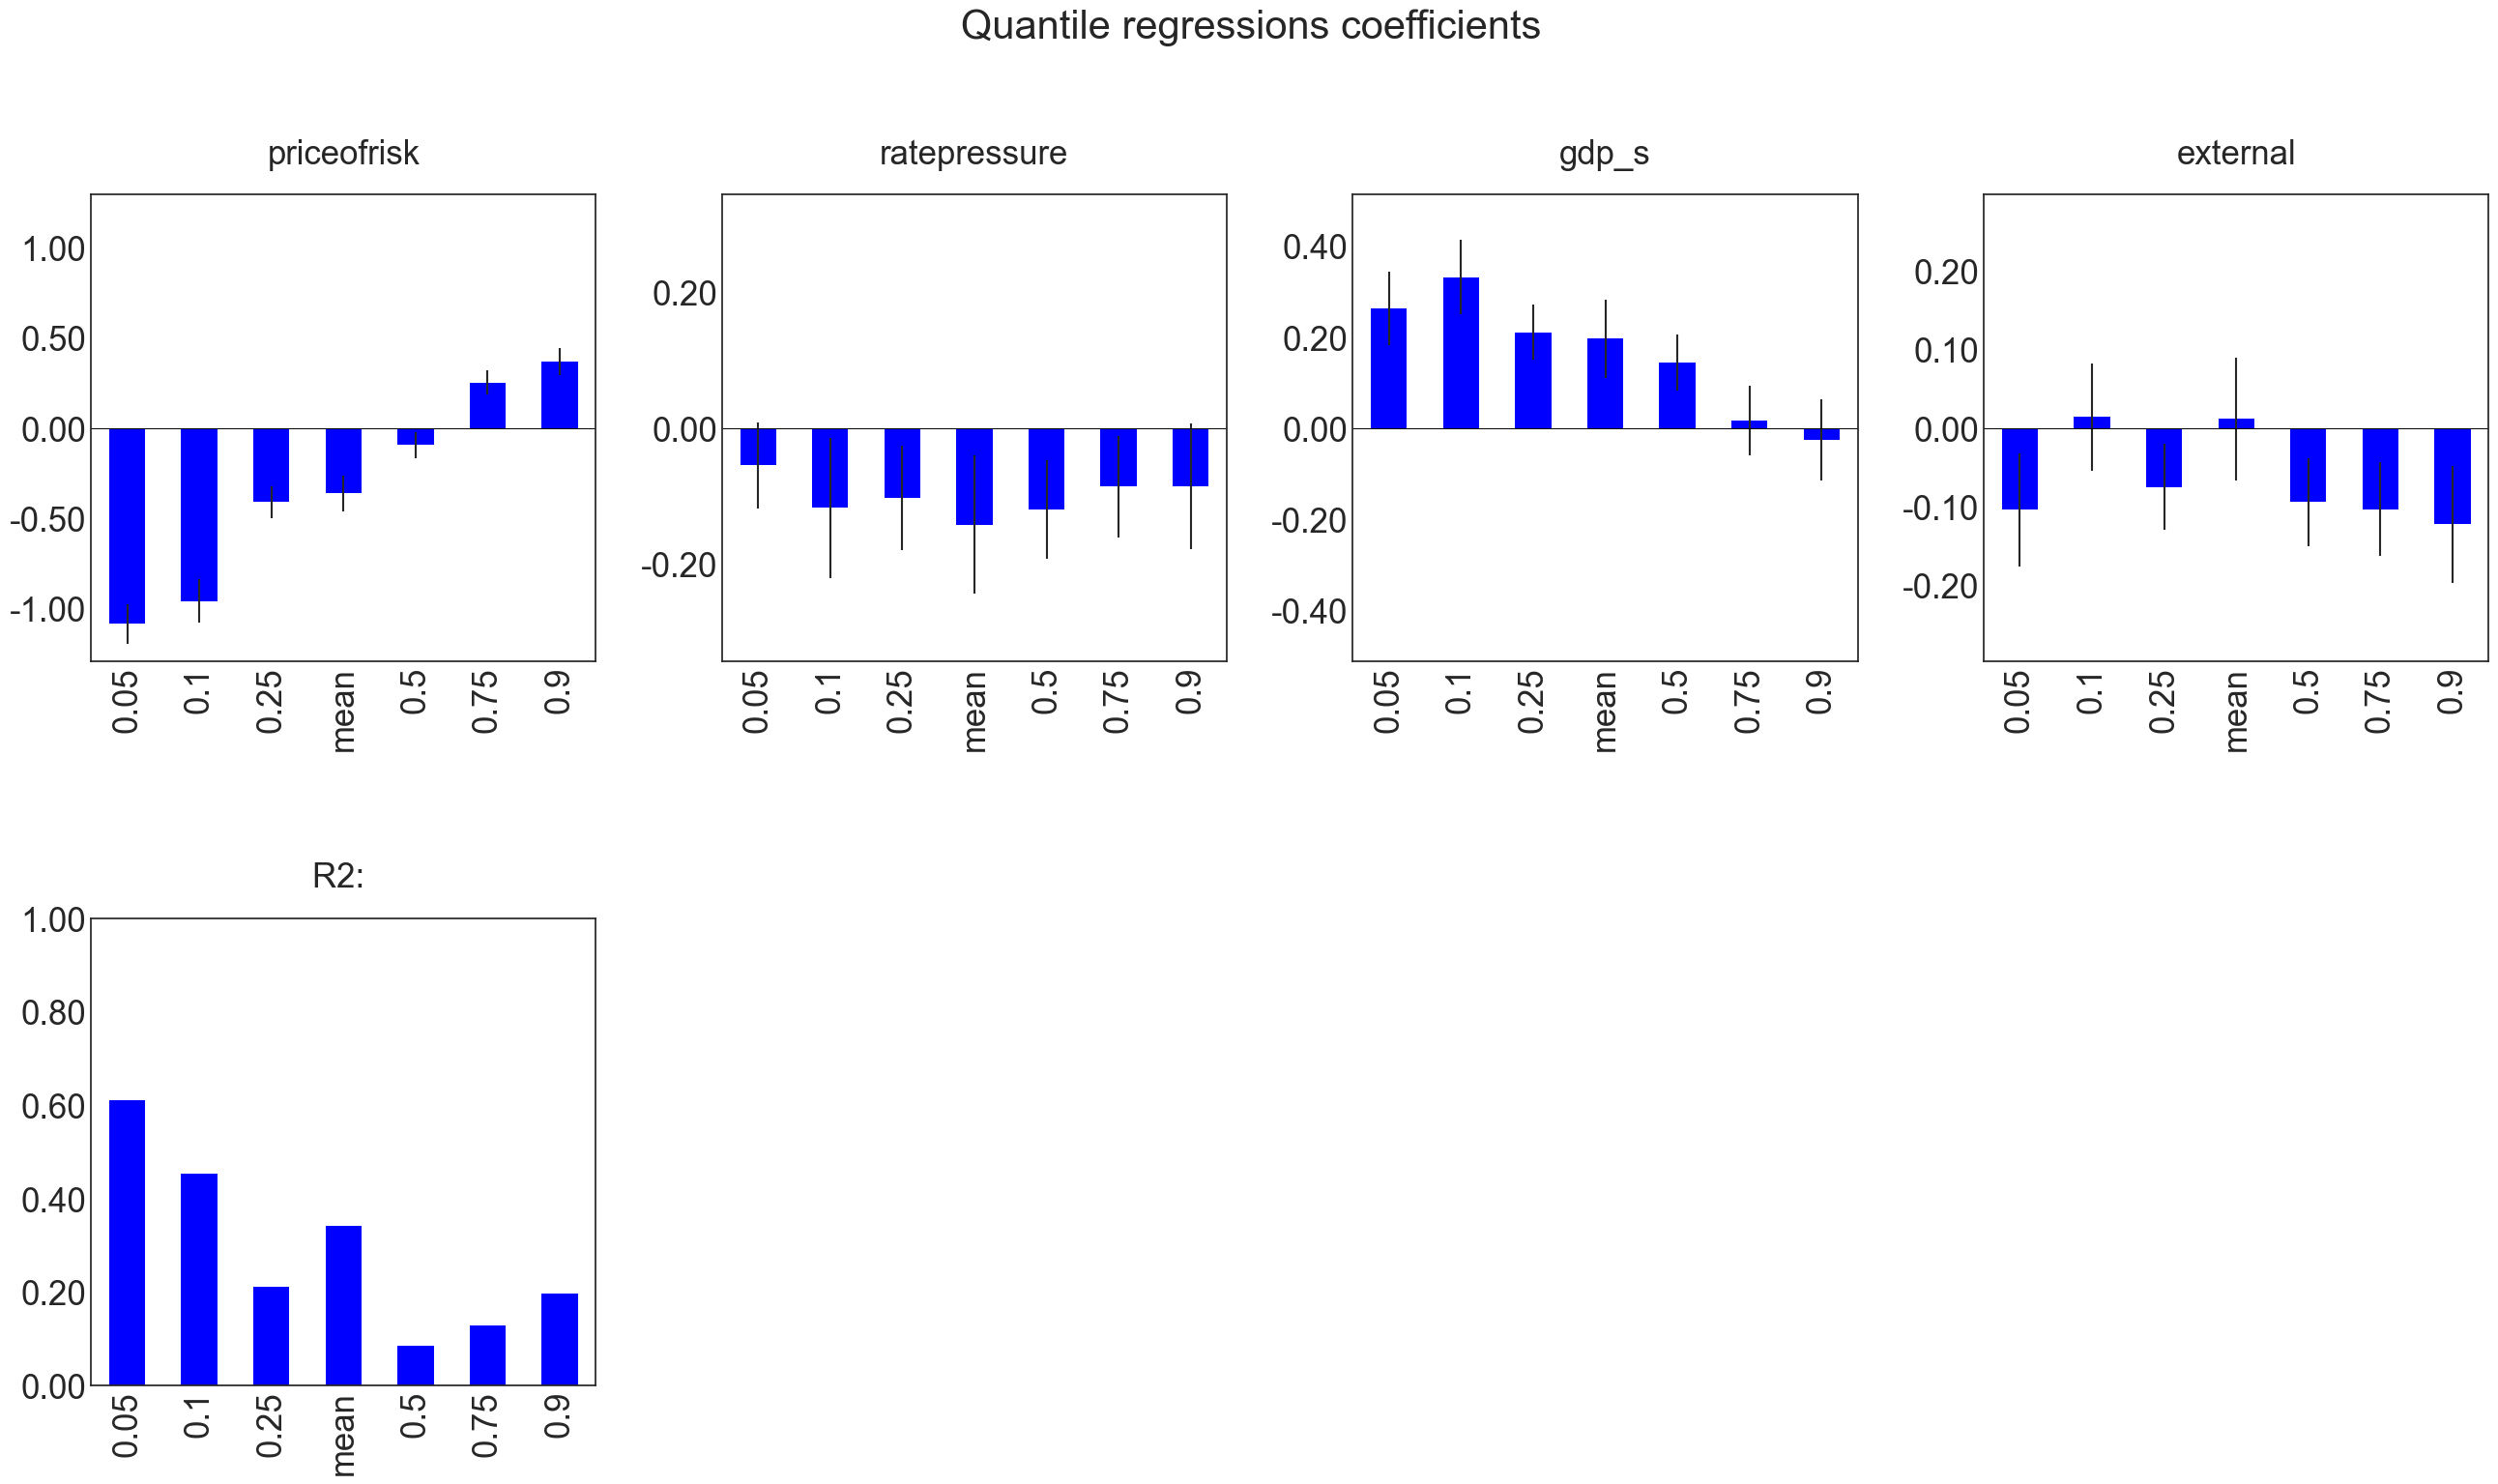

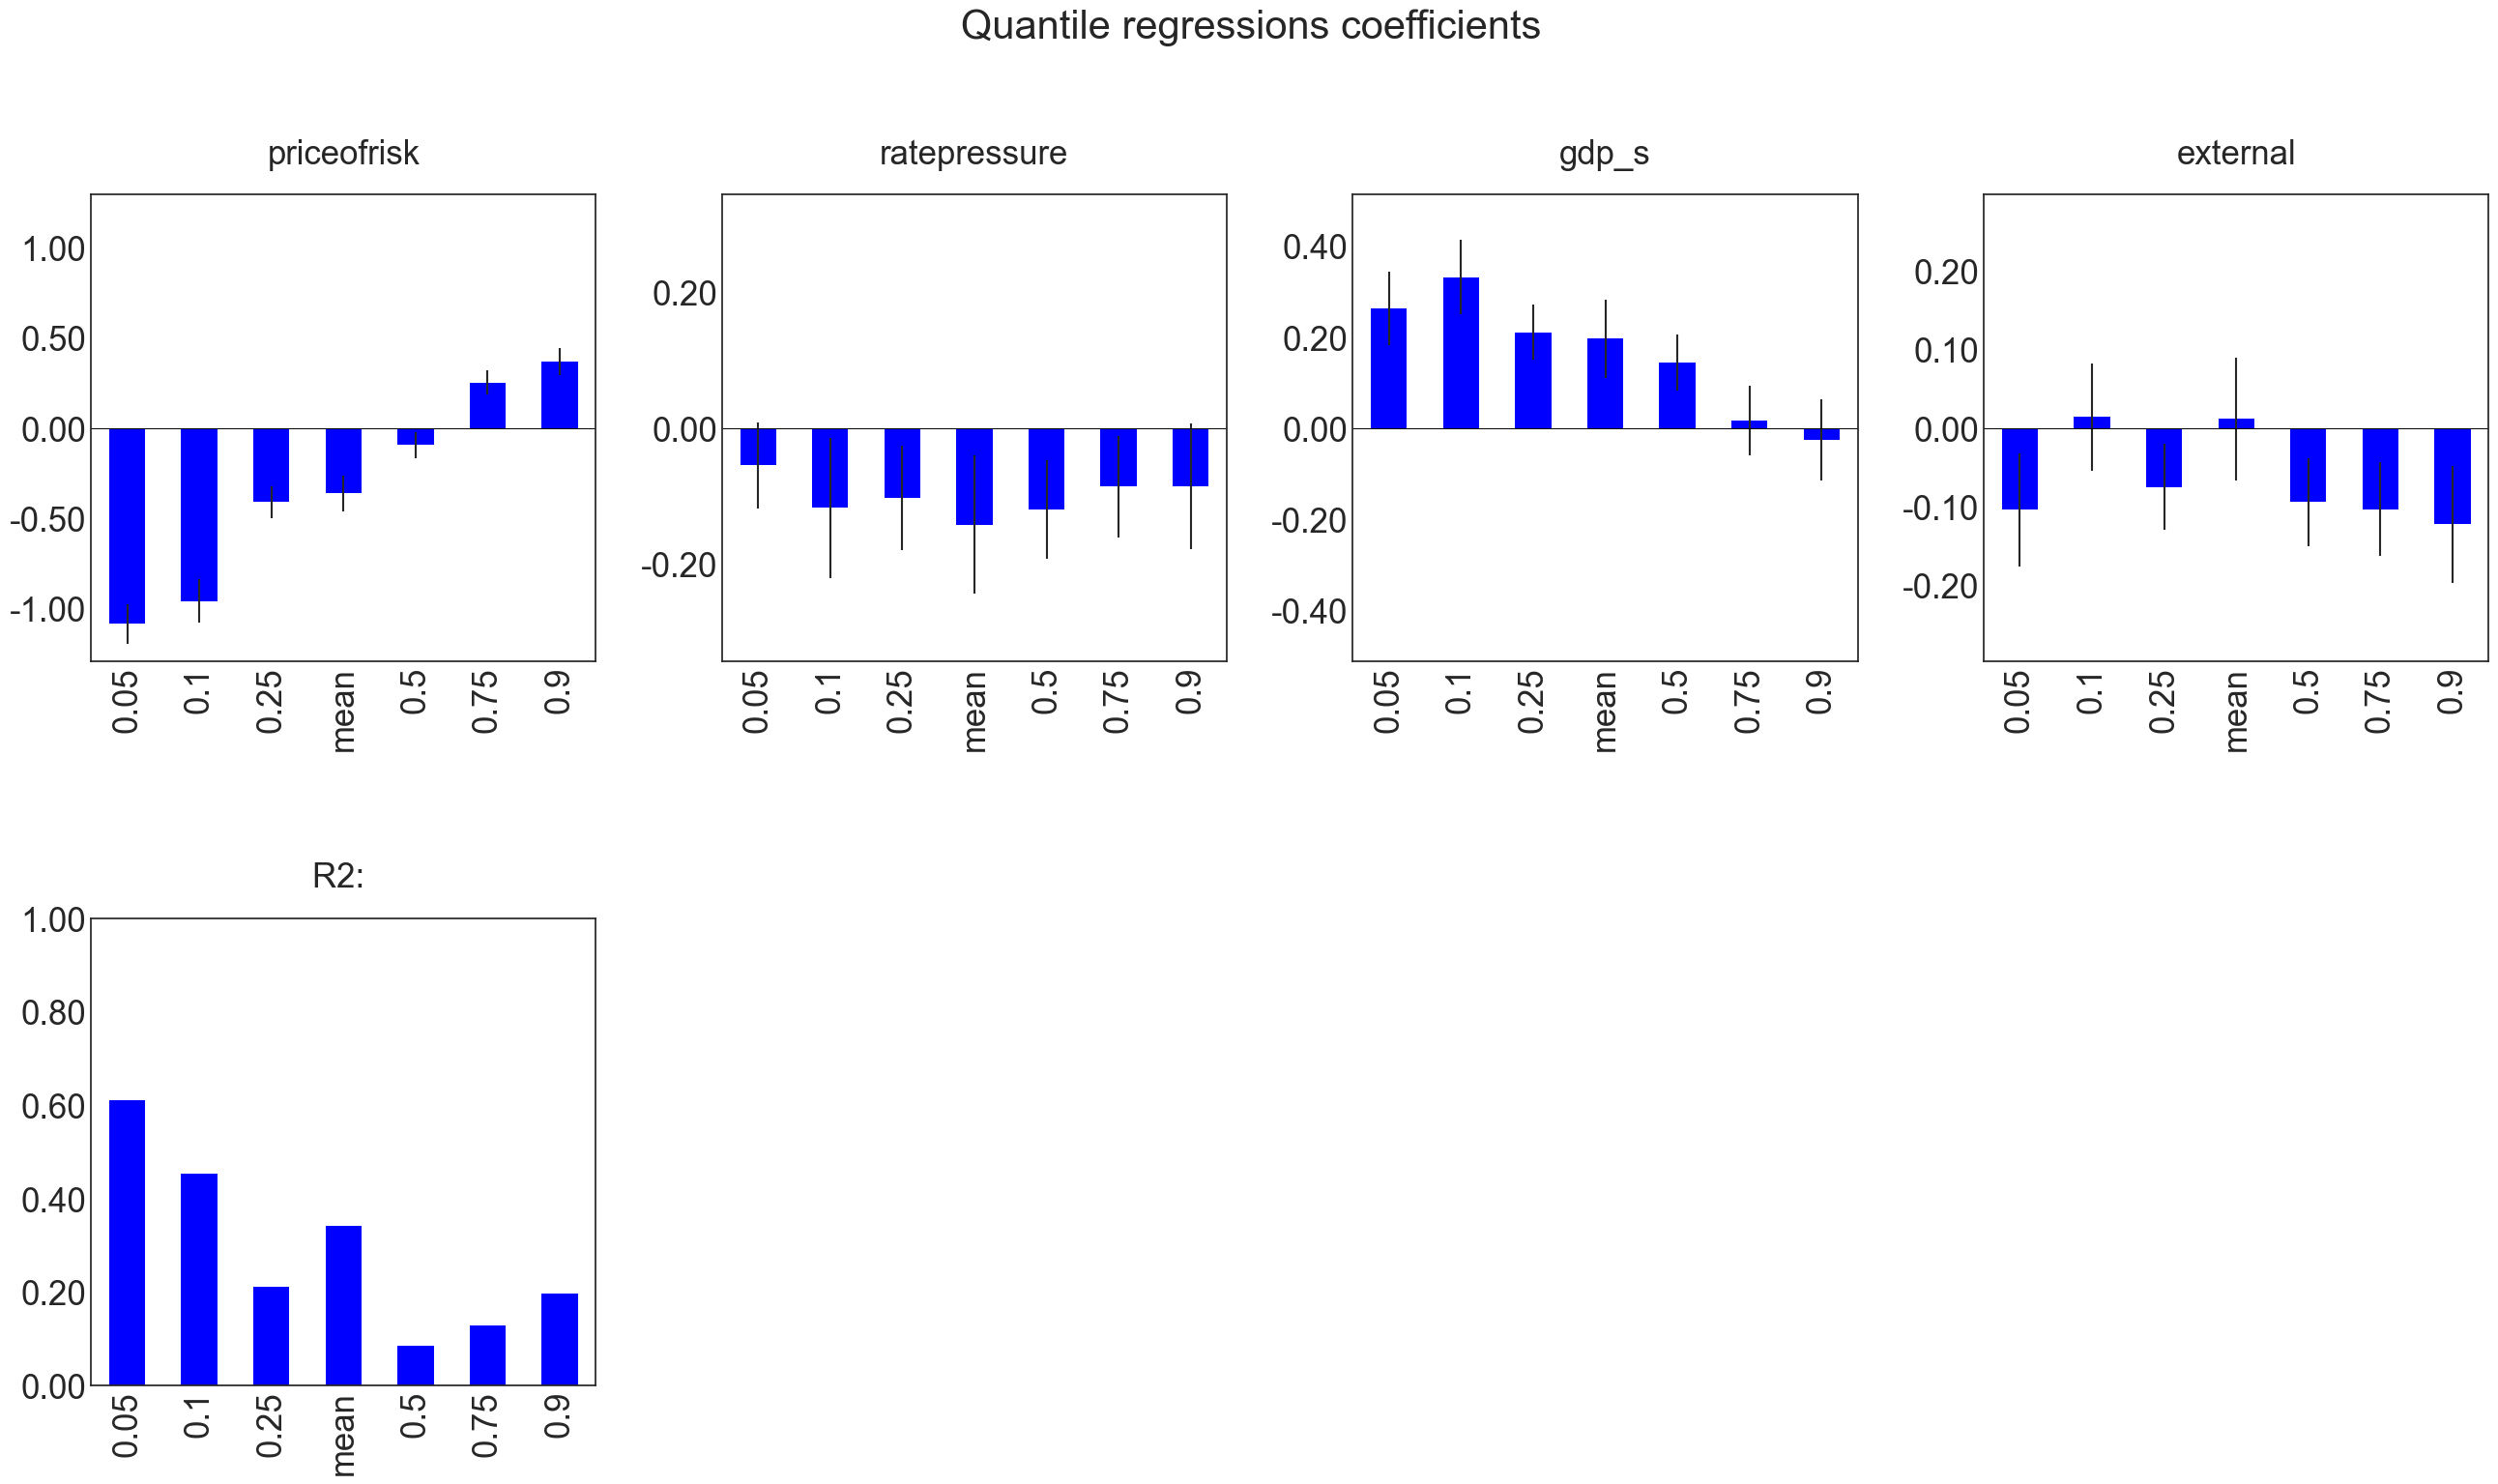

In [156]:
coeff_plot(dcoeffc = Qresult.coeff , regressors = {'external', 'gdp_s', 'priceofrisk', 'ratepressure'}, qlist = ql)

In [157]:
cond_quantdf = Qresult.cond_quant

In [158]:
cond_quantdf

,tau,realized_value,conditional_quantile_mean,conditional_quantile_mean_se,conditional_quantile_mean_ci_lower,conditional_quantile_mean_ci_upper,conditional_quantile_obs_ci_lower,conditional_quantile_obs_ci_upper
Date,,,,,,,,
2004-01-31,0.05,0.062200,-2.635400,0.118484,-2.869154,-2.401646,-4.622070,-0.648730
2004-02-29,0.05,-0.741155,-2.136788,0.129756,-2.392779,-1.880796,-4.126196,-0.147379
2004-03-31,0.05,0.120603,-2.184108,0.144933,-2.470042,-1.898175,-4.177591,-0.190626
2004-04-30,0.05,-0.073915,-1.937886,0.124131,-2.182780,-1.692991,-3.925897,0.050126
2004-05-31,0.05,0.208818,-1.700257,0.154618,-2.005298,-1.395216,-3.696570,0.296056
...,...,...,...,...,...,...,...,...
2019-07-31,mean,-4.000219,-1.677653,0.253421,-2.177619,-1.177687,-3.378612,0.023307
2019-08-31,mean,-4.053367,-1.957578,0.267593,-2.485504,-1.429652,-3.666965,-0.248191
2019-09-30,mean,-3.563054,-2.943595,0.380789,-3.694843,-2.192347,-4.734592,-1.152598


In [180]:
quantile2018 = cond_quantdf[cond_quantdf.index == '2018-01-31']

In [181]:
quantile2018

,tau,realized_value,conditional_quantile_mean,conditional_quantile_mean_se,conditional_quantile_mean_ci_lower,conditional_quantile_mean_ci_upper,conditional_quantile_obs_ci_lower,conditional_quantile_obs_ci_upper
Date,,,,,,,,
2018-01-31,0.05,-0.446839,-1.914619,0.078251,-2.068999,-1.760240,-3.893520,0.064281
2018-01-31,0.1,-0.446839,-1.620763,0.081831,-1.782205,-1.459321,-3.600227,0.358702
2018-01-31,0.25,-0.446839,-0.619914,0.061201,-0.740657,-0.499172,-2.596476,1.356647
2018-01-31,0.5,-0.446839,-0.019599,0.051755,-0.121704,0.082507,-1.995109,1.955912
2018-01-31,0.75,-0.446839,0.625408,0.048399,0.529922,0.720893,-1.349772,2.600587
2018-01-31,0.9,-0.446839,0.919859,0.056895,0.807612,1.032106,-1.056202,2.895919
2018-01-31,mean,-0.446839,-0.218001,0.072443,-0.360922,-0.075079,-1.850092,1.414091


In [161]:
cond_quantdf['conditional_quantile_mean'].idxmin()

Timestamp('2019-11-30 00:00:00')

In [162]:
GaRdf = cond_quantdf[cond_quantdf['tau'] == 0.05]

In [163]:
GaRdf['conditional_quantile_mean'].idxmin() #GaR was highest in 2020-11-30, according to data in 2019-11-30

Timestamp('2019-11-30 00:00:00')

In [184]:
os.makedirs('Data', exist_ok=True)  
cond_quantdf.to_csv('Data/contquantdf.csv')